In [1]:
# General Imports
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Imports for data mangling
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RepeatedKFold

# Imports for GP Regressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

In [2]:
data = pd.read_csv('Credit.csv', index_col='Obs')
data.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
Obs,,,,,,,,,,,
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


In [3]:
index_train, index_valid  = train_test_split(data.index, train_size=0.7, random_state=10)

# Write training and validation sets 
train = data.loc[index_train, :].copy() 
valid =  data.loc[index_valid, :].copy()

# Response label
response = 'Balance'

# Response vectors 
y_train = train[response]
y_valid = valid[response]

train.head()

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
Obs,,,,,,,,,,,
400,18.701,5524,415,5,64,7,Female,No,No,Asian,966
26,14.090,4323,326,5,25,16,Female,No,Yes,African American,671
280,54.319,3063,248,3,59,8,Female,Yes,No,Caucasian,269
261,67.937,5184,383,4,63,12,Male,No,Yes,Asian,345
131,23.793,3821,281,4,56,12,Female,Yes,Yes,African American,868


In [4]:
predictors = ['Limit', 'Income'] 
X_train = train[predictors] 

https://planspace.org/20181226-gaussian_processes_are_not_so_fancy/

https://arxiv.org/pdf/1012.2599.pdf

https://machinelearningmastery.com/what-is-bayesian-optimization/

# KNN

In [5]:
class GaussianProcessV2:
    def __init__(self, x=None, y=None, length_scale=1, stretch=1, kernel=RBF()):
        self.x = x
        self.y = y
        self.model = GaussianProcessRegressor(kernel=kernel)
        
        self._fit_model()
        
    def _fit_model(self):
        if self.x is None or self.y is None:
            return
        
        self.model.fit(self.x, self.y)
    
    def mean(self, x1):
        if len(x1.shape) == 1:
            x1 = x1.reshape(-1, 1)
        
        return self.model.predict(x1, return_std=False)
    
    def std(self, x1):
        if len(x1.shape) == 1:
            x1 = x1.reshape(-1, 1)
        
        _, std = self.model.predict(x1, return_std=True)
        return std
    
    def update_prior(self, x1, y1):
        assert isinstance(x1, (int, float)), "x1 only accepts integer or float values"
        assert isinstance(y1, (int, float)), "y1 only accepts integer or float values"
        
        if self.x is not None:
            self._check_if_in_prior(x1, e=1e-7)
        
            self.x = np.concatenate([self.x, np.array([[x1]])])
            self.y = np.concatenate([self.y, np.array([y1])])
        else:
            self.x = np.array([[x1]])
            self.y = np.array([y1])
            
        self._fit_model()
            
    def _check_if_in_prior(self, x1, e=1e-7):
        if np.any(abs(self.x - x1) < e):
            raise ValueError(f"The given datapoint, {x1} is already in the priors and will not be added.")

In [6]:
def get_knn_error(n_neighbours):
    knn = KNeighborsRegressor(n_neighbors=n_neighbours, 
                              metric='mahalanobis', metric_params={'V': X_train.cov()})
    
    rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=100)
    scores = cross_val_score(knn, X_train, y_train, 
                             cv=rkf, scoring='neg_mean_squared_error')
    
    rmse = np.sqrt(-1*np.mean(scores))
    return rmse

cv_error_for_knn = [get_knn_error(k) for k in np.arange(1, 21)]

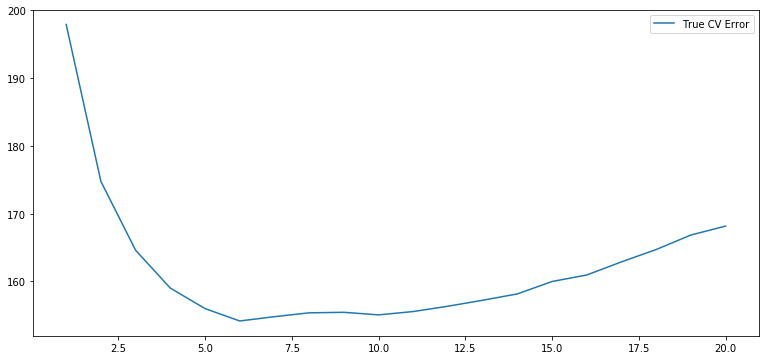

In [7]:
plt.figure(figsize=(13, 6))

plt.plot(np.arange(1, 21), cv_error_for_knn, label='True CV Error')

plt.legend();

In [30]:
gp = GaussianProcessV2(kernel=RBF() * 2)

In [47]:
gp.__dict__

{'x': array([[ 4],
        [20],
        [13],
        [ 6]]),
 'y': array([159.02824912, 168.16945263, 157.23153615, 154.17804417]),
 'model': GaussianProcessRegressor(kernel=RBF(length_scale=1) * 1.41**2)}

In [31]:
len(X_train)

280

In [43]:
k = 6

knn = KNeighborsRegressor(n_neighbors=k, metric='mahalanobis', metric_params={'V': X_train.cov()})

rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=100)
scores = cross_val_score(knn, X_train, y_train, cv=rkf, scoring='neg_mean_squared_error')

rmse = np.sqrt(-1*np.mean(scores))
print(f"k = {k}; RMSE = {rmse}")

k = 6; RMSE = 154.17804417476424


In [44]:
gp.update_prior(k, rmse)

In [45]:
list(zip(gp.x, gp.y))

[(array([4]), 159.02824911900763),
 (array([20]), 168.16945262570303),
 (array([13]), 157.23153614788984),
 (array([6]), 154.17804417476424)]

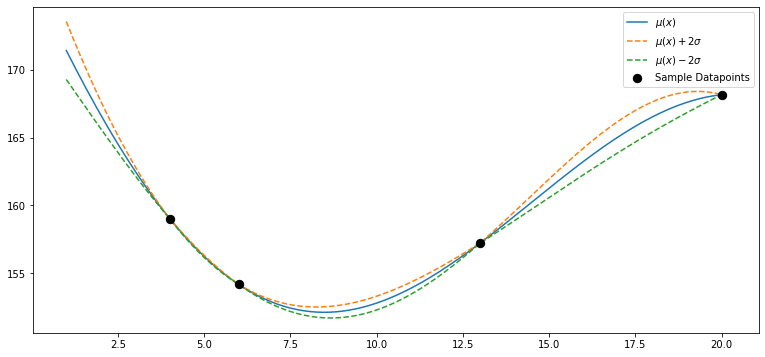

In [46]:
plt.figure(figsize=(13, 6))
x_vals = np.linspace(1, 20, 200)

plt.plot(x_vals, gp.mean(x_vals), label='$\mu(x)$')
plt.plot(x_vals, gp.mean(x_vals) + 2 * gp.std(x_vals), '--', label='$\mu(x) + 2\sigma$')
plt.plot(x_vals, gp.mean(x_vals) - 2 * gp.std(x_vals), '--', label='$\mu(x) - 2\sigma$')

plt.scatter(gp.x.flatten(), gp.y, s=70, label='Sample Datapoints', color='Black', zorder=5)
plt.legend();

In [145]:
5 / 6

0.8333333333333334

# GP Estimation vs True CV Error

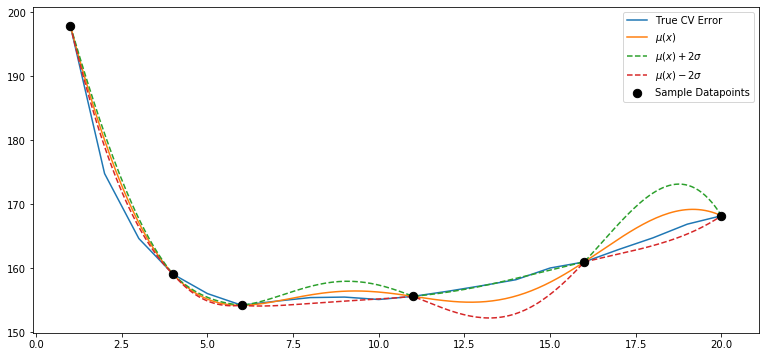

In [169]:
plt.figure(figsize=(13, 6))

# Plot the CV Error
plt.plot(np.arange(1, 21), cv_error_for_knn, label='True CV Error')

# Plot the GP
x_vals = np.linspace(1, 20, 200)

plt.plot(x_vals, gp.mean(x_vals), label='$\mu(x)$')
plt.plot(x_vals, gp.mean(x_vals) + 2 * gp.std(x_vals), '--', label='$\mu(x) + 2\sigma$')
plt.plot(x_vals, gp.mean(x_vals) - 2 * gp.std(x_vals), '--', label='$\mu(x) - 2\sigma$')

plt.scatter(gp.x.flatten(), gp.y, s=70, label='Sample Datapoints', color='Black', zorder=5)
plt.legend();